In [8]:
import os  
import pandas as pd  
import re  
import emoji  
import numpy as np  
import nltk  
from sklearn.model_selection import train_test_split  
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.preprocessing import LabelEncoder  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import classification_report, confusion_matrix  
import seaborn as sns  
import matplotlib.pyplot as plt  
from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize  
from nltk.stem import WordNetLemmatizer  

 
nltk.download('punkt')  
nltk.download('stopwords')  
nltk.download('wordnet')  

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\And3w\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\And3w\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\And3w\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

In [10]:
def preprocess_tweet(tweet):
    tweet = emoji.replace_emoji(tweet, replace='')

    tweet = re.sub(r'[:;=X][-o*]?[)D\(\[Pp/\\|\\]|O|3><]', '', tweet)
    tweet = re.sub(r'[^\x00-\x7F]+', '', tweet)
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'@\w+|#\w+', '', tweet)
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)

    tweet = tweet.lower()

    words = word_tokenize(tweet)

    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    return ' '.join(words)

In [11]:
folders = [  
    ('Emotion_Dataset/AngerData.csv', 'Anger'),  
    ('Emotion_Dataset/FearData.csv', 'Fear'),  
    ('Emotion_Dataset/JoyData.csv', 'Joy'),  
    ('Emotion_Dataset/LoveData.csv', 'Love'),  
    ('Emotion_Dataset/NeutralData.csv', 'Neutral'),  
    ('Emotion_Dataset/SadData.csv', 'Sad')  
]  

train_dfs = []  
test_dfs = []  

for file_path, label in folders:
    df = pd.read_csv(file_path, sep='\t')  
    
    df['cleaned_tweet'] = df['Tweet'].apply(preprocess_tweet)  
     
    df['Label'] = label  
     
    train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['Label'])  
      
    train_dfs.append(train_df)  
    test_dfs.append(test_df)  
 
train_combined = pd.concat(train_dfs, ignore_index=True)  
test_combined = pd.concat(test_dfs, ignore_index=True)  

train_combined.reset_index(drop=True, inplace=True)  
test_combined.reset_index(drop=True, inplace=True)  

train_result = train_combined[['cleaned_tweet', 'Label']]  
test_result = test_combined[['cleaned_tweet', 'Label']]

In [12]:
tfidf_vectorizer = TfidfVectorizer(  
    max_features=5000,      
    ngram_range=(1, 2),     
    stop_words='english',  
    min_df=2,               
    max_df=0.95           
)  

X_train_tfidf = tfidf_vectorizer.fit_transform(train_result['cleaned_tweet'])  
X_test_tfidf = tfidf_vectorizer.transform(test_result['cleaned_tweet'])  

le = LabelEncoder()  
y_train = le.fit_transform(train_result['Label'])  
y_test = le.transform(test_result['Label'])  

In [15]:
print("Training Dataset Size:", X_train_tfidf.shape)  
print("Test Dataset Size:", X_test_tfidf.shape)  
print("\nLabel Distribution:")  
print(train_result['Label'].value_counts())  


clf = RandomForestClassifier(  
    n_estimators=100,   
    random_state=42,   
    n_jobs=-1 
)  
clf.fit(X_train_tfidf, y_train)  

y_pred = clf.predict(X_test_tfidf)  

Training Dataset Size: (4951, 5000)
Test Dataset Size: (2126, 5000)

Label Distribution:
Label
Neutral    1400
Joy         892
Anger       788
Sad         702
Fear        637
Love        532
Name: count, dtype: int64



Classification Report:
              precision    recall  f1-score   support

       Anger       0.72      0.65      0.69       339
        Fear       0.78      0.77      0.77       274
         Joy       0.77      0.67      0.72       383
        Love       0.60      0.84      0.70       228
     Neutral       0.61      0.67      0.64       601
         Sad       0.77      0.60      0.68       301

    accuracy                           0.69      2126
   macro avg       0.71      0.70      0.70      2126
weighted avg       0.70      0.69      0.69      2126



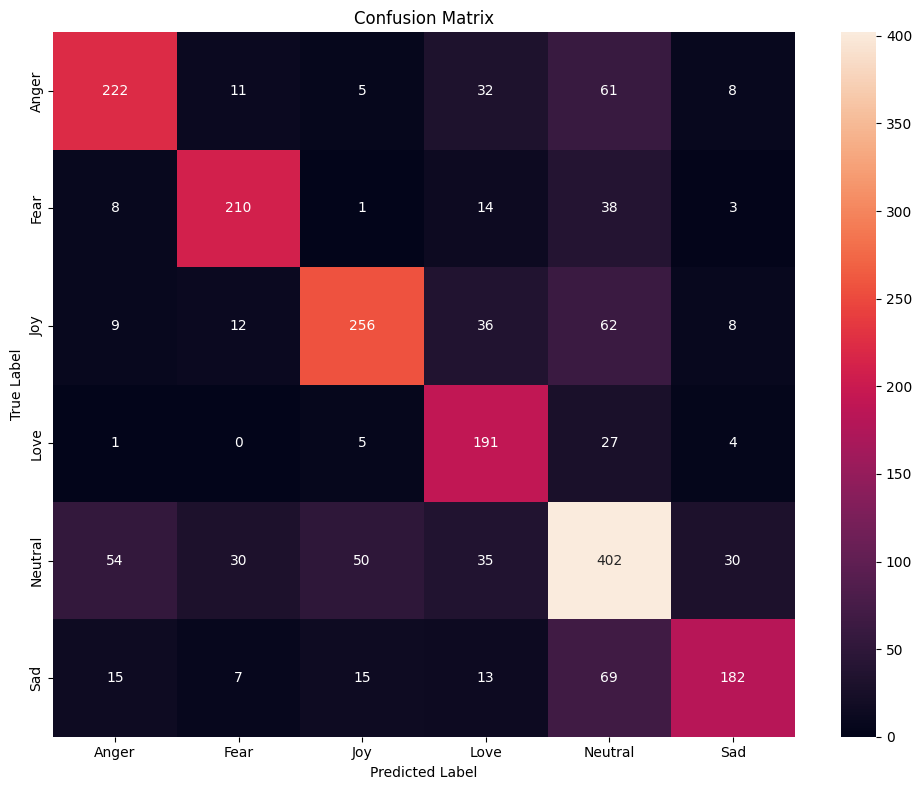

In [16]:
print("\nClassification Report:")  
print(classification_report(y_test, y_pred, target_names=le.classes_))  

plt.figure(figsize=(10,8))  
cm = confusion_matrix(y_test, y_pred)  
sns.heatmap(cm, annot=True, fmt='d',   
            xticklabels=le.classes_,   
            yticklabels=le.classes_)  
plt.title('Confusion Matrix')  
plt.xlabel('Predicted Label')  
plt.ylabel('True Label')  
plt.tight_layout()  
plt.show()  
 
feature_names = tfidf_vectorizer.get_feature_names_out()  
feature_importances = clf.feature_importances_  
top_features = sorted(zip(feature_importances, feature_names), reverse=True)[:20]  

In [17]:
print("\nTop 20 Important Features:")  
for importance, feature in top_features:  
    print(f"{feature}: {importance}")


Top 20 Important Features:
sedih: 0.04194158439764004
semangat: 0.03860048414447677
takut: 0.0345675783148573
banget: 0.02044814126489417
suka: 0.02042325602132168
saja: 0.015515490614362677
tolol: 0.012332813559027284
suka banget: 0.012197375664479688
biasa: 0.012098727651309461
ngeri: 0.011999553664159416
emosi: 0.010031238261108067
enak: 0.009272341786441351
bangsat: 0.008574660040387793
marah: 0.007359060571647962
kaget: 0.006614671035319047
bodoh: 0.006587865313122859
malu: 0.006142379464351615
benci: 0.0059564654438951795
kecewa: 0.005767440200716883
aku: 0.005210485660106005
